### Банковская гарантия — соглашение, по которому банк обязан выплатить долг клиента, если тот не выполнил своих обязательств. Выдача гарантий банком происходит после одобрения клиентской заявки.

Задача-построить аппликационную модель оценки вероятности предъявления по гарантии, чтобы минимизировать потери от кредитного риска. В качестве предикторов для моделирования используются анкетные данные клиента и его финансовые показатели.

Решения оцениваются по метрике ROC/AUC Score.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as ctb
from sklearn import  model_selection, metrics 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score,train_test_split,TimeSeriesSplit
%matplotlib inline

In [2]:
data_train=pd.read_csv('train_dataset_hackathon_mkb.csv',encoding='cp1251', sep=';')
data_test=pd.read_csv('test_dataset_hackathon_mkb.csv',encoding='cp1251', sep=';')

In [3]:
description=pd.read_csv('data_description.csv',sep=';')#загрузка файла с описанием фичей
description=description.set_index('Название поля')
description.index.name=None

# к описанию фичей добавляем долю пропусков
total = data_train.isnull().sum().sort_values(ascending=False)
percent = (data_train.isnull().sum()/data_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


descr_miss=pd.merge(missing_data, description, left_index=True, right_index=True)


descr_miss.head()

,Total,Percent,Описание
FLAG_DISQUALIFICATION,17886,0.999721,"Наличие руководителя компании, дисквалифициров..."
F1320,17794,0.994578,"Собственные акции, выкупленные у акционеров"
COUNT_CHANGE_YEAR,17652,0.986641,Количество изменений в наименовании и организа...
F2310,17590,0.983176,Доходы от участия в других организациях
F1160,17545,0.980661,Доходные вложения в материальные ценности


In [4]:
#функция для обработки признаков, в которых есть дата
def date_format(name_features,data):
    for name_feature in name_features:
        
        list_year=[]
        list_months=[]
        list_day=[]

        dict_months={'APR':4,
     'AUG':7,
     'DEC':12,
     'FEB':2,
     'JAN':1,
     'JUL':7,
     'JUN':6,
     'MAR':3,
     'MAY':5,
     'NOV':11,
     'OCT':10,
     'SEP':9}

        for date in data[name_feature]:
            if type(date)!=float:
                list_year.append(int(date[5:9]))
                list_months.append(int(dict_months[date[2:5]]))
                list_day.append(int(date[0:2]))
            else:
                list_year.append(0)
                list_months.append(0)
                list_day.append(0)

        data[str(name_feature)+'_YEAR']=pd.Series(list_year,dtype='int64')
        data[str(name_feature)+'_MONTH']=pd.Series(list_months,dtype='int64')
        data[str(name_feature)+'_DAY']=pd.Series(list_day,dtype='int64')
    
        data=data.drop([name_feature],axis=1)
    
    return data

#обработка ОКТМО кодов
def oktmo_code(data):
    data['OKTMO_CODE']=data['OKTMO_CODE'].fillna(0)
    oktmo_code=data['OKTMO_CODE']


    oktmo_code_edited=[]
    for i in range(len(oktmo_code)):
        oktmo_code_edited.append(str(oktmo_code[i])[0:2])
    
    for i in range(len(oktmo_code_edited)):
        if oktmo_code_edited[i]=='0.':
            oktmo_code_edited[i]=int(0)
        else:
            oktmo_code_edited[i]=int(oktmo_code_edited[i])
    
    
    data['OKTMO_CODE']=oktmo_code_edited

    # фичи okato_fed и okato_regioncode вцелом несут всю ту же информацию ,поэтому не так важны
    data=data.drop(['OKATO_FED','OKATO_REGIONCODE','OKTMO_FED'],axis=1)
    return data


# обработка ОКВЭД кодов

def okved_code(data):
    data['OKVED_CODE']=data['OKVED_CODE'].fillna(0)

    code_list=list(set(data['OKVED_CODE']))

    okved_code_list=[]
    for code in code_list:
        if code!=np.nan:
            okved_code_list.append(str(code)[0:2])
        
        
    list_okved=list(data['OKVED_CODE'])
    for i in range(len(list_okved)):
        if i!=np.nan:
            list_okved[i]=int(str(list_okved[i])[0:2])
        else:
            list_okved[i]=int(0)
        
        
    data['OKVED_CODE']=list_okved
    return data

In [5]:
def preproc_features(data):
    #превращение категориальных фичей в бинарные
    data=data.merge(pd.get_dummies(data[['OKFS_GROUP','OKOPF_GROUP',
                                                           'OKOGU_GROUP','WORKERSRANGE']]),left_index=True, right_index=True)
    data=data.drop(['OKFS_GROUP','OKOPF_GROUP','OKOGU_GROUP',
                                'WORKERSRANGE','BIRTHDATE',
                                'SEX_NAME','CITIZENSHIP_NAME'],axis=1)

    data=data.drop(['TAXREGPAY_REGDATE_MONTH','TAXREGPAY_REGDATE_DAY',
                                'TAXREG_REGDATE_MONTH','TAXREG_REGDATE_DAY',
                                'DATEFIRSTREG_DAY','DATEFIRSTREG_MONTH'],axis=1)
    
    data[['EGRPOINCLUDED', 'COUNTCOOWNERFCSM',
       'COUNTCOOWNERROSSTAT', 'COUNTCOOWNEREGRUL', 'COUNTBRANCH',
       'COUNTBRANCHROSSTAT', 'COUNTBRANCHEGRUL', 'TELEPHONECOUNT',
       'MANAGERCOUNTINCOUNTRY', 'MANAGERCOUNTINREGION', 'MANAGERINNCOUNT']]=data[['EGRPOINCLUDED', 'COUNTCOOWNERFCSM',
                                                                                                       'COUNTCOOWNERROSSTAT', 'COUNTCOOWNEREGRUL', 'COUNTBRANCH',
                                                                                                       'COUNTBRANCHROSSTAT', 'COUNTBRANCHEGRUL', 'TELEPHONECOUNT',
                                                                                                       'MANAGERCOUNTINCOUNTRY', 'MANAGERCOUNTINREGION', 'MANAGERINNCOUNT']].fillna(0).astype('int32')
    return data

In [6]:
def history_of_contracts(data_train, data_test):
    #в данной функции подсчитывается наличие контрактов у клиента при подписании нового
    # как выполненных так и не выполненных
    
    
    sorted_data_train=data_train.sort_values(['SIGN_DATE_YEAR',
                                        'SIGN_DATE_MONTH','SIGN_DATE_DAY'])
    list_cnt_of_signs=[0]
    executed_contracts=[0]
    not_executed_contracts=[0]

    for i in range(1,len(sorted_data_train)):
    
        id_client=sorted_data_train.loc[i].id_client
        list_cnt_of_signs.append(len(sorted_data_train.loc[0:i-1][sorted_data_train.loc[0:i-1]['id_client']==id_client]))       
        executed_contracts.append(len(sorted_data_train.loc[0:i-1][(sorted_data_train.loc[0:i-1]['id_client']==id_client) & (sorted_data_train.loc[0:i-1]['TARGET']==1)]))
        not_executed_contracts.append(len(sorted_data_train.loc[0:i-1][(sorted_data_train.loc[0:i-1]['id_client']==id_client) & (sorted_data_train.loc[0:i-1]['TARGET']==0)]))
    

    sorted_data_train['NUMBER_OF_EARLY_CONTRACTS']=pd.Series(list_cnt_of_signs,dtype='int64')
    sorted_data_train['NUMBER_OF_EXECUTED_CONTRACTS_EARLY']=pd.Series(executed_contracts,dtype='int64')
    sorted_data_train=sorted_data_train.sort_values(['SIGN_DATE_YEAR','SIGN_DATE_MONTH','SIGN_DATE_DAY'])
        
    # для теста информация о контрактах попросту приписывается в соответсвии с количеством
    #контрактов на момент подписания последнего (в трейне)
     
    list_cnt_of_signs=[]
    executed_contracts=[]
    not_executed_contracts=[]

    for i in range(len(data_test)):
    
        id_client=data_test.loc[i].id_client
        list_cnt_of_signs.append(len(sorted_data_train[sorted_data_train['id_client']==id_client]))       
        executed_contracts.append(len(sorted_data_train[(sorted_data_train['id_client']==id_client) & (sorted_data_train['TARGET']==1)]))
        not_executed_contracts.append(len(sorted_data_train[(sorted_data_train['id_client']==id_client) & (sorted_data_train['TARGET']==0)]))
    
        data_test['NUMBER_OF_EARLY_CONTRACTS']=pd.Series(list_cnt_of_signs,dtype='int64')
        data_test['NUMBER_OF_EXECUTED_CONTRACTS_EARLY']=pd.Series(executed_contracts,dtype='int64')
        data_test=data_test.sort_values(['SIGN_DATE_YEAR','SIGN_DATE_MONTH','SIGN_DATE_DAY'])
       
    return sorted_data_train,data_test


In [7]:
%%time
dates_features=['SIGN_DATE','DATEFIRSTREG','TAXREG_REGDATE','TAXREGPAY_REGDATE']# фичи с датами, которые разбиваются на год,месяц,день
data_train=date_format(dates_features,data=data_train)

data_test=date_format(dates_features,data_test)


data_train=oktmo_code(data_train)
data_train=okved_code(data_train)

data_test=oktmo_code(data_test)
data_test=okved_code(data_test)

data_train=preproc_features(data_train)
data_test=preproc_features(data_test)

sorted_data_train,data_test=history_of_contracts(data_train, data_test)

Wall time: 4min 3s


In [8]:
sorted_data_train

,id_contract,id_client,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,...,WORKERSRANGE_151 .. 200,WORKERSRANGE_16 .. 50,WORKERSRANGE_201 .. 250,WORKERSRANGE_251 .. 500,WORKERSRANGE_5000 и более,WORKERSRANGE_501 .. 1000,WORKERSRANGE_51 .. 100,WORKERSRANGE_6 .. 10,NUMBER_OF_EARLY_CONTRACTS,NUMBER_OF_EXECUTED_CONTRACTS_EARLY
0,1,1847,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2,4650,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,3,4770,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
3,4,12237,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,356828000.0,...,0,0,0,0,0,1,0,0,0,0
4,5,9988,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17886,17887,3439,0,0,5.404500e+07,NaN,5.404500e+07,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
17887,17888,838,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
17888,17889,10537,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
17889,17890,1751,0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


#### Всех клиентов можно разделить на 4 класса:
 1) Новые клиенты ИП
 2) Старые клиенты (клиенты,у которых есть история контрактов с банком) ИП
 3) Новые юр.лица
 4) старые юр.лица
И далее уже для каждой из этих категорий отдельно решается задача классификации.

## 1) Новые ИП

In [9]:
#выделяем кусок ИП клиентов
def new_IP_clients(sorted_data_train,data_test,percent_of_missed=76):
    
    #отбор и обработка трейна
    new_clients_IP=sorted_data_train.drop(['NUMBER_OF_EARLY_CONTRACTS','NUMBER_OF_EXECUTED_CONTRACTS_EARLY'],axis=1)
    id_new_clients_IP=sorted_data_train[(sorted_data_train['NUMBER_OF_EARLY_CONTRACTS']==0) & (sorted_data_train.IP_flag==1)]['id_contract']
    new_clients_IP=new_clients_IP.loc[sorted_data_train['id_contract'].isin(id_new_clients_IP)]
    
    
    description=pd.read_csv('data_description.csv',sep=';')
    description=description.set_index('Название поля')
    description.index.name=None


    total = new_clients_IP.isnull().sum().sort_values(ascending=False)
    percent = (new_clients_IP.isnull().sum()/new_clients_IP.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    descr_miss=pd.merge(missing_data, description, left_index=True, right_index=True)
    drop_feats_IP=list(descr_miss[descr_miss['Percent']>(percent_of_missed/100)].index)
    
    # правда остаются неинформативные колонки у которых во всех строчках одно знаечние, их тоже следует удалить
    for col in new_clients_IP.columns:
        if len(list(set(new_clients_IP[col])))==1:
            new_clients_IP=new_clients_IP.drop(col,axis=1)
        
        
    #заполнить нулями и сделать интами
    list_float_features=['PLAINTIFF_CASESNUMBER_YEAR','PLAINTIFF_SUM_YEAR','THIRDOROTHERPERSON_YEAR',
                     'PLAINTIFF_CASESNUMBER_EVER','DEFENDANT_CASESNUMBER_EVER','DEFENDANT_SUM_EVER','THIRDOROTHERPERSON_EVER','AGE','DEFENDANT_CASESNUMBER_YEAR','DEFENDANT_SUM_YEAR','PLAINTIFF_SUM_EVER']

    new_clients_IP[list_float_features]=new_clients_IP[list_float_features].fillna(0).astype('int32')

    new_clients_IP=new_clients_IP.sort_values(['SIGN_DATE_YEAR','SIGN_DATE_MONTH','SIGN_DATE_DAY'])
    new_clients_IP=new_clients_IP.drop(drop_feats_IP+['id_contract','id_client','AGE','SIGN_DATE_YEAR','SIGN_DATE_MONTH',
                                        'SIGN_DATE_DAY'],axis=1)
    

    new_clients_IP_target=new_clients_IP['TARGET']
    new_clients_IP=new_clients_IP.drop(['TARGET'],axis=1)
    
    
    #отбор и обработка теста 
    
    data_test_new_IP_clients=data_test

    indexes_of_new_IP_clients_test=data_test[(data_test['NUMBER_OF_EARLY_CONTRACTS']==0) & (data_test['IP_flag']==1)].index
    data_test_new_IP_clients=data_test_new_IP_clients.iloc[indexes_of_new_IP_clients_test]
    
    data_test_new_IP_clients_id_contract=data_test.iloc[indexes_of_new_IP_clients_test]['id_contract']
    
    data_test_new_IP_clients[list_float_features]=data_test_new_IP_clients[list_float_features].fillna(0).astype('int32')
    data_test_new_IP_clients=data_test_new_IP_clients[new_clients_IP.columns]
    
    return new_clients_IP,new_clients_IP_target,data_test_new_IP_clients,data_test_new_IP_clients_id_contract

In [10]:
%%time
new_clients_IP,new_clients_IP_target,data_test_new_IP_clients,data_test_new_IP_clients_id_contract=new_IP_clients(sorted_data_train,data_test,percent_of_missed=76)

Wall time: 5.53 s


C:\Users\mi\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
%%time
ctb_new_IP_clf=ctb.CatBoostClassifier(verbose=0)
param_grid = {
    'iterations' : [1000],
    "learning_rate": [0.01],
'depth':[4]}

tscv=TimeSeriesSplit(n_splits=3)
cat_grid_new_IP=GridSearchCV(ctb_new_IP_clf,param_grid,cv=tscv,n_jobs=1,verbose=3,scoring='roc_auc')


cat_grid_new_IP.fit(new_clients_IP,new_clients_IP_target)
print(cat_grid_new_IP.best_params_)

best_new_IP_cat=cat_grid_new_IP.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END depth=4, iterations=1000, learning_rate=0.01;, score=0.731 total time=   1.9s
[CV 2/3] END depth=4, iterations=1000, learning_rate=0.01;, score=0.759 total time=   0.9s
[CV 3/3] END depth=4, iterations=1000, learning_rate=0.01;, score=0.669 total time=   2.4s
{'depth': 4, 'iterations': 1000, 'learning_rate': 0.01}
Wall time: 8.55 s


In [12]:
#важность фичей
feature_importances3=best_new_IP_cat.feature_importances_
feature_importances_df3=pd.DataFrame({'features':list(new_clients_IP),
                                     'feature_importances3':feature_importances3})
feature_importances_df3=feature_importances_df3.sort_values('feature_importances3',ascending=False)
feature_importances_df3.head()

,features,feature_importances3
1,OKVED_CODE,37.743944
0,OKTMO_CODE,14.493669
7,DATEFIRSTREG_YEAR,10.743324
9,TAXREGPAY_REGDATE_YEAR,9.991479
8,TAXREG_REGDATE_YEAR,9.750285


## 2) Старые ИП

In [13]:
pd.options.mode.chained_assignment = None  # default='warn'

#выделяем кусое ИП клиентов
def new_not_IP_clients(sorted_data_train,data_test,percent_of_missed=80):
    
    #обработка тренйа
    new_clients_not_IP=sorted_data_train.drop(['NUMBER_OF_EARLY_CONTRACTS','NUMBER_OF_EXECUTED_CONTRACTS_EARLY'],axis=1)

    id_new_clients_not_IP=sorted_data_train[(sorted_data_train['NUMBER_OF_EARLY_CONTRACTS']==0) & (sorted_data_train.IP_flag==0)]['id_contract']

    new_clients_not_IP=new_clients_not_IP.loc[data_train['id_contract'].isin(id_new_clients_not_IP)]

    description=pd.read_csv('data_description.csv',sep=';')
    description=description.set_index('Название поля')
    description.index.name=None


    total = new_clients_not_IP.isnull().sum().sort_values(ascending=False)
    percent = (new_clients_not_IP.isnull().sum()/new_clients_not_IP.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    descr_miss=pd.merge(missing_data, description, left_index=True, right_index=True)

    drop_feats_IP=list(descr_miss[descr_miss['Percent']>(percent_of_missed/100)].index)

    #список натуральных фичей, заменить на нули
    list_features_not_IP_1=['EGRPOINCLUDED',
 'OKTMO_CODE','COUNTCOOWNERFCSM','COUNTCOOWNERROSSTAT','COUNTCOOWNEREGRUL','COUNTBRANCH','COUNTBRANCHROSSTAT','COUNTBRANCHEGRUL','TELEPHONECOUNT',
 'MANAGERCOUNTINCOUNTRY','MANAGERCOUNTINREGION','MANAGERINNCOUNT','OKVED_CODE','PLAINTIFF_CASESNUMBER_YEAR','PLAINTIFF_SUM_YEAR',
 'DEFENDANT_CASESNUMBER_YEAR','DEFENDANT_SUM_YEAR','THIRDOROTHERPERSON_YEAR','PLAINTIFF_CASESNUMBER_EVER','PLAINTIFF_SUM_EVER',
 'DEFENDANT_CASESNUMBER_EVER','DEFENDANT_SUM_EVER','THIRDOROTHERPERSON_EVER','ADMITTEDNUMBER_233_YEAR','NOTADMITTEDNUMBER_233_YEAR','WINNERNUMBER_233_YEAR',
 'SIGNEDNUMBER_233_YEAR','SUM_233_YEAR','ADMITTEDNUMBER_233_EVER','NOTADMITTEDNUMBER_233_EVER','WINNERNUMBER_233_EVER','SIGNEDNUMBER_233_EVER',
 'SUM_233_EVER','ADMITTEDNUMBER_95_YEAR','NOTADMITTEDNUMBER_95_YEAR','WINNERNUMBER_95_YEAR',
 'SIGNEDNUMBER_95_YEAR','SUM_95_YEAR','ADMITTEDNUMBER_95_EVER','NOTADMITTEDNUMBER_EVER','WINNERNUMBER_95_EVER',
 'SIGNEDNUMBER_95_EVER','SUM_95_EVER','FLAG_DISQUALIFICATION','COUNT_CHANGE_YEAR','COUNT_CHANGE_EVER']


    list_features_not_IP_2=['F1100','F1110','F1150','F1160','F1170','F1180','F1190','F1200','F1210','F1220','F1230',
 'F1240','F1250','F1260','F1300','F1310','F1320','F1350','F1360','F1370','F1400','F1410','F1420',
 'F1450','F1500','F1510','F1520','F1530','F1550','F1600','F1700','F2100','F2110','F2120','F2200','F2210','F2220','F2300','F2310','F2320','F2330',
 'F2340','F2350','F2400','F2410','F1150_LAG1','F1230_LAG1','F1410_LAG1',
 'F1510_LAG1','F1520_LAG1','F2110_LAG1','F2120_LAG1','F2200_LAG1','F2210_LAG1','F2220_LAG1','F2300_LAG1','F2320_LAG1','F2330_LAG1','F2400_LAG1']

    for col in list_features_not_IP_1:
        new_clients_not_IP[col]=new_clients_not_IP[col].fillna(0).astype('int32')
    
    for col in list_features_not_IP_2:
        new_clients_not_IP[col]=new_clients_not_IP[col].fillna(0).astype('int32')
        
        
    new_clients_not_IP=new_clients_not_IP.sort_values(['SIGN_DATE_YEAR','SIGN_DATE_MONTH','SIGN_DATE_DAY'])
    
    new_clients_not_IP_target=new_clients_not_IP['TARGET']
    new_clients_not_IP=new_clients_not_IP.drop(drop_feats_IP+['id_contract','id_client','IP_flag','SIGN_DATE_YEAR','SIGN_DATE_MONTH','SIGN_DATE_DAY','TARGET'],axis=1)

    
    #обработка теста
    data_test_new_not_IP_clients=data_test

    #здесь выбираются столбцы для того,чтобы фичи совпадали с трейном

    indexes_of_new_not_IP_clients_test=data_test[(data_test['NUMBER_OF_EARLY_CONTRACTS']==0) & (data_test['IP_flag']==0)].index
    data_test_new_not_IP_clients=data_test_new_not_IP_clients.iloc[indexes_of_new_not_IP_clients_test]
    data_test_new_not_IP_clients_id_contract=data_test.iloc[indexes_of_new_not_IP_clients_test]['id_contract']


    for col in list_features_not_IP_1:
        data_test_new_not_IP_clients[col]=data_test_new_not_IP_clients[col].fillna(0).astype('int32')
    
    for col in list_features_not_IP_2:
        data_test_new_not_IP_clients[col]=data_test_new_not_IP_clients[col].fillna(0).astype('int32')

    data_test_new_not_IP_clients=data_test_new_not_IP_clients[new_clients_not_IP.columns]
    
    return new_clients_not_IP_target,new_clients_not_IP,data_test_new_not_IP_clients,data_test_new_not_IP_clients_id_contract

In [14]:
new_clients_not_IP_target,new_clients_not_IP,data_test_new_not_IP_clients,data_test_new_not_IP_clients_id_contract=new_not_IP_clients(sorted_data_train,data_test,percent_of_missed=80)

In [15]:
%%time
ctb_new_not_IP_clf=ctb.CatBoostClassifier(verbose=0)
param_grid = {
    'iterations' : [1300],
    "learning_rate": [0.01],
'depth':[7]}

tscv=TimeSeriesSplit(n_splits=3)
cat_grid_new_not_IP=GridSearchCV(ctb_new_not_IP_clf,param_grid,cv=tscv,n_jobs=1,verbose=4,scoring='roc_auc')


cat_grid_new_not_IP.fit(new_clients_not_IP,new_clients_not_IP_target)
cat_grid_new_not_IP.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END depth=7, iterations=1300, learning_rate=0.01;, score=0.790 total time=  28.0s
[CV 2/3] END depth=7, iterations=1300, learning_rate=0.01;, score=0.756 total time=  28.7s
[CV 3/3] END depth=7, iterations=1300, learning_rate=0.01;, score=0.844 total time=  31.0s
Wall time: 2min 1s


{'depth': 7, 'iterations': 1300, 'learning_rate': 0.01}

In [16]:
best_new_not_IP_cat=cat_grid_new_not_IP.best_estimator_

In [17]:
#важность фичей
feature_importances3=best_new_not_IP_cat.feature_importances_
feature_importances_df3=pd.DataFrame({'features':list(new_clients_not_IP),
                                     'feature_importances3':feature_importances3})
feature_importances_df3=feature_importances_df3.sort_values('feature_importances3',ascending=False)
feature_importances_df3.head()

,features,feature_importances3
50,OKVED_CODE,8.651596
39,OKTMO_CODE,4.687832
98,WORKERSRANGE_0 .. 5,3.660106
79,SIGNEDNUMBER_95_EVER,2.735311
90,OKOPF_GROUP_Коммерческая корпоративная организ...,2.468709


## 3) Старые ИП

In [18]:
def old_IP_clients(sorted_data_train,percent_of_missed_data=70):
    
    #обработка трейна
    #добавляем столбец с количеством контрактов ранее и количеством выполненных
    old_clients_IP=pd.merge(data_train, sorted_data_train[['id_contract','NUMBER_OF_EARLY_CONTRACTS','NUMBER_OF_EXECUTED_CONTRACTS_EARLY']], on="id_contract")

    #записываем индексы старых клиентов
    indexes_of_old_clients_IP=sorted_data_train[(sorted_data_train['NUMBER_OF_EARLY_CONTRACTS']>0) & (sorted_data_train['IP_flag']==1)].index


    old_clients_IP=old_clients_IP.iloc[indexes_of_old_clients_IP]
    id_contr_old_IP=old_clients_IP['id_contract']
    old_clients_IP=old_clients_IP.loc[old_clients_IP['id_contract'].isin(id_contr_old_IP)]


    description=pd.read_csv('data_description.csv',sep=';')
    description=description.set_index('Название поля')
    description.index.name=None


    total = old_clients_IP.isnull().sum().sort_values(ascending=False)
    percent = (old_clients_IP.isnull().sum()/old_clients_IP.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


    descr_miss=pd.merge(missing_data, description, left_index=True, right_index=True)

    drop_feats_old_IP=list(descr_miss[descr_miss['Percent']>(percent_of_missed_data/100)].index)

    #заполнить нулями и сделать интами
    list_float_features_old_IP=['PLAINTIFF_CASESNUMBER_YEAR','PLAINTIFF_SUM_YEAR','THIRDOROTHERPERSON_YEAR',
                     'PLAINTIFF_CASESNUMBER_EVER','DEFENDANT_CASESNUMBER_EVER','DEFENDANT_SUM_EVER','THIRDOROTHERPERSON_EVER','AGE','DEFENDANT_CASESNUMBER_YEAR','DEFENDANT_SUM_YEAR','PLAINTIFF_SUM_EVER']

    old_clients_IP[list_float_features_old_IP]=old_clients_IP[list_float_features_old_IP].fillna(0).astype('int32')

    old_clients_IP=old_clients_IP.drop(drop_feats_old_IP,axis=1)
    
    # правда остаются неинформативные колонки у которых во всех строчках одно знаечние, их тоже следует удалить
    for col in old_clients_IP.columns:
        if len(list(set(old_clients_IP[col])))==1:
            old_clients_IP=old_clients_IP.drop(col,axis=1)
            
    old_clients_IP=old_clients_IP.drop(['id_contract','id_client'],axis=1)
    old_clients_IP_target=old_clients_IP['TARGET']
    old_clients_IP=old_clients_IP.drop(['TARGET','SIGN_DATE_YEAR','SIGN_DATE_MONTH','SIGN_DATE_DAY'],axis=1)
    
    
    
    #обработка теста
    data_test_old_IP_clients=data_test

    #здесь выбираются столбцы для того,чтобы фичи совпадали с трейном

    indexes_of_old_IP_clients_test=data_test[(data_test['NUMBER_OF_EARLY_CONTRACTS']>0) & (data_test['IP_flag']==1)].index
    data_test_old_IP_clients=data_test_old_IP_clients.iloc[indexes_of_old_IP_clients_test]

    
    data_test_old_IP_clients_id_contract=data_test.iloc[indexes_of_old_IP_clients_test]['id_contract']
    data_test_old_IP_clients[list_float_features_old_IP]=data_test_old_IP_clients[list_float_features_old_IP].fillna(0).astype('int32')
    data_test_old_IP_clients=data_test_old_IP_clients[old_clients_IP.columns]
    
    return data_test_old_IP_clients,old_clients_IP_target,old_clients_IP,data_test_old_IP_clients_id_contract

In [19]:
data_test_ol_IP_clients,old_clients_IP_target,old_clients_IP,data_test_old_IP_clients_id_contract=old_IP_clients(sorted_data_train,percent_of_missed_data=70)

In [20]:
%%time
ctb_old_IP_clf=ctb.CatBoostClassifier(verbose=0)
param_grid = {
    'iterations' : [400],
               "learning_rate": [0.001],
'depth':[2,4,5,7]}

tscv=TimeSeriesSplit(n_splits=3)
cat_grid_old_IP=GridSearchCV(ctb_old_IP_clf,param_grid,cv=tscv,n_jobs=1,verbose=4,scoring='roc_auc')


cat_grid_old_IP.fit(old_clients_IP,old_clients_IP_target)
cat_grid_old_IP.best_params_
best_old_IP_cat=cat_grid_old_IP.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END depth=2, iterations=400, learning_rate=0.001;, score=0.984 total time=   0.2s
[CV 2/3] END depth=2, iterations=400, learning_rate=0.001;, score=0.984 total time=   0.3s
[CV 3/3] END depth=2, iterations=400, learning_rate=0.001;, score=0.994 total time=   0.4s
[CV 1/3] END depth=4, iterations=400, learning_rate=0.001;, score=0.986 total time=   0.2s
[CV 2/3] END depth=4, iterations=400, learning_rate=0.001;, score=0.985 total time=   0.4s
[CV 3/3] END depth=4, iterations=400, learning_rate=0.001;, score=0.995 total time=   0.5s
[CV 1/3] END depth=5, iterations=400, learning_rate=0.001;, score=0.981 total time=   0.4s
[CV 2/3] END depth=5, iterations=400, learning_rate=0.001;, score=0.984 total time=   0.5s
[CV 3/3] END depth=5, iterations=400, learning_rate=0.001;, score=0.995 total time=   0.7s
[CV 1/3] END depth=7, iterations=400, learning_rate=0.001;, score=0.983 total time=   0.5s
[CV 2/3] END depth=7, iteratio

In [21]:
feature_importances3=best_old_IP_cat.feature_importances_
feature_importances_df3=pd.DataFrame({'features':list(old_clients_IP),
                                     'feature_importances3':feature_importances3})
feature_importances_df3=feature_importances_df3.sort_values('feature_importances3',ascending=False)
feature_importances_df3.head()

,features,feature_importances3
6,NUMBER_OF_EXECUTED_CONTRACTS_EARLY,54.525672
1,OKVED_CODE,28.094893
5,NUMBER_OF_EARLY_CONTRACTS,6.080568
4,TAXREGPAY_REGDATE_YEAR,4.355562
3,TAXREG_REGDATE_YEAR,3.133000


## 4) Старые ИП клиенты

In [22]:
def old_IP_clients(sorted_data_train,percent_of_missed_data=75):
    
    #обработка трейна
    
    #добавляем столбец с количеством контрактов ранее и количеством выполненных
    old_clients_not_IP=pd.merge(data_train, sorted_data_train[['id_contract','NUMBER_OF_EARLY_CONTRACTS','NUMBER_OF_EXECUTED_CONTRACTS_EARLY']], on="id_contract")

    #записываем индексы старых клиентов
    indexes_of_old_clients_not_IP=sorted_data_train[(sorted_data_train['NUMBER_OF_EARLY_CONTRACTS']>0) & (sorted_data_train['IP_flag']==0)].index


    old_clients_not_IP=old_clients_not_IP.iloc[indexes_of_old_clients_not_IP]
    id_contr_old_not_IP=old_clients_not_IP['id_contract']
    old_clients_not_IP=old_clients_not_IP.loc[old_clients_not_IP['id_contract'].isin(id_contr_old_not_IP)]
    
    description=pd.read_csv('data_description.csv',sep=';')
    description=description.set_index('Название поля')
    description.index.name=None


    total = old_clients_not_IP.isnull().sum().sort_values(ascending=False)
    percent = (old_clients_not_IP.isnull().sum()/old_clients_not_IP.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


    descr_miss=pd.merge(missing_data, description, left_index=True, right_index=True)

    drop_feats_old_not_IP=list(descr_miss[descr_miss['Percent']>(percent_of_missed_data/100)].index)
    
    
    list_float_features_old_IP=['PLAINTIFF_CASESNUMBER_YEAR','PLAINTIFF_SUM_YEAR','THIRDOROTHERPERSON_YEAR',
                     'PLAINTIFF_CASESNUMBER_EVER','DEFENDANT_CASESNUMBER_EVER','DEFENDANT_SUM_EVER','THIRDOROTHERPERSON_EVER','AGE','DEFENDANT_CASESNUMBER_YEAR','DEFENDANT_SUM_YEAR','PLAINTIFF_SUM_EVER']

    list_features_not_IP_2=['F1100','F1110','F1150','F1160','F1170','F1180','F1190','F1200','F1210','F1220','F1230',
 'F1240','F1250','F1260','F1300','F1310','F1320','F1350','F1360','F1370','F1400','F1410','F1420',
 'F1450','F1500','F1510','F1520','F1530','F1550','F1600','F1700','F2100','F2110','F2120','F2200','F2210','F2220','F2300','F2310','F2320','F2330',
 'F2340','F2350','F2400','F2410','F1150_LAG1','F1230_LAG1','F1410_LAG1',
 'F1510_LAG1','F1520_LAG1','F2110_LAG1','F2120_LAG1','F2200_LAG1','F2210_LAG1','F2220_LAG1','F2300_LAG1','F2320_LAG1','F2330_LAG1','F2400_LAG1']
    
    old_clients_not_IP[list_float_features_old_IP]=old_clients_not_IP[list_float_features_old_IP].fillna(0).astype('int32')
    old_clients_not_IP[list_features_not_IP_2]=old_clients_not_IP[list_features_not_IP_2].fillna(0).astype('int32')
    #old_clients_not_IP=old_clients_not_IP.drop(['id_contract','id_client','SIGN_DATE_YEAR','SIGN_DATE_MONTH','SIGN_DATE_MONTH','SIGN_DATE_DAY'],axis=1)
    old_clients_not_IP=old_clients_not_IP.drop(drop_feats_old_not_IP+['id_contract','id_client','SIGN_DATE_YEAR','SIGN_DATE_MONTH','SIGN_DATE_MONTH','SIGN_DATE_DAY'],axis=1)
    
    # правда остаются неинформативные колонки у которых во всех строчках одно знаечние, их тоже следует удалить
    for col in old_clients_not_IP.columns:
        if len(list(set(old_clients_not_IP[col])))==1:
            old_clients_not_IP=old_clients_not_IP.drop(col,axis=1)
            
    old_clients_not_IP_target=old_clients_not_IP['TARGET']
    old_clients_not_IP=old_clients_not_IP.drop(['TARGET'],axis=1)
    
    
    #обработка теста
    
    data_test_old_not_IP_clients=data_test
 
    indexes_of_old_not_IP_clients_test=data_test[(data_test['NUMBER_OF_EARLY_CONTRACTS']>0) & (data_test['IP_flag']==0)].index
    data_test_old_not_IP_clients=data_test_old_not_IP_clients.iloc[indexes_of_old_not_IP_clients_test]

    data_test_old_not_IP_clients_id_contract=data_test.iloc[indexes_of_old_not_IP_clients_test]['id_contract']

    data_test_old_not_IP_clients[list_features_not_IP_2]=data_test_old_not_IP_clients[list_features_not_IP_2].fillna(0).astype('int32')

    #здесь выбираются столбцы для того,чтобы фичи совпадали с трейном
    data_test_old_not_IP_clients=data_test_old_not_IP_clients[old_clients_not_IP.columns]
    
    return data_test_old_not_IP_clients,old_clients_not_IP,old_clients_not_IP_target,data_test_old_not_IP_clients_id_contract

In [23]:
data_test_old_not_IP_clients,old_clients_not_IP,old_clients_not_IP_target,data_test_old_not_IP_clients_id_contract=old_IP_clients(sorted_data_train,percent_of_missed_data=75)

In [24]:
%%time
ctb_old_not_IP_clf=ctb.CatBoostClassifier(verbose=0)
param_grid = {
    'iterations' : [1000,1300],
               "learning_rate": [0.01],
'depth':[2,3,4]}

tscv=TimeSeriesSplit(n_splits=3)
cat_grid_old_not_IP=GridSearchCV(ctb_old_not_IP_clf,param_grid,cv=tscv,n_jobs=1,verbose=4,scoring='roc_auc')


cat_grid_old_not_IP.fit(old_clients_not_IP,old_clients_not_IP_target)
cat_grid_old_not_IP.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END depth=2, iterations=1000, learning_rate=0.01;, score=0.992 total time=   2.0s
[CV 2/3] END depth=2, iterations=1000, learning_rate=0.01;, score=0.993 total time=   2.4s
[CV 3/3] END depth=2, iterations=1000, learning_rate=0.01;, score=0.992 total time=   2.8s
[CV 1/3] END depth=2, iterations=1300, learning_rate=0.01;, score=0.992 total time=   2.8s
[CV 2/3] END depth=2, iterations=1300, learning_rate=0.01;, score=0.993 total time=   3.7s
[CV 3/3] END depth=2, iterations=1300, learning_rate=0.01;, score=0.992 total time=   4.2s
[CV 1/3] END depth=3, iterations=1000, learning_rate=0.01;, score=0.993 total time=   2.5s
[CV 2/3] END depth=3, iterations=1000, learning_rate=0.01;, score=0.993 total time=   3.1s
[CV 3/3] END depth=3, iterations=1000, learning_rate=0.01;, score=0.991 total time=   4.2s
[CV 1/3] END depth=3, iterations=1300, learning_rate=0.01;, score=0.993 total time=   3.5s
[CV 2/3] END depth=3, iteratio

{'depth': 4, 'iterations': 1300, 'learning_rate': 0.01}

In [25]:
best_old_not_IP_cat=cat_grid_old_not_IP.best_estimator_

# Используем все четыре классификатора для предсказания 

In [26]:
def full_answer():
    answer_new_IP=pd.DataFrame(data_test_new_IP_clients_id_contract)
    answer_new_IP['TARGET']=list(best_new_IP_cat.predict_proba(data_test_new_IP_clients)[:,1])

    answer_new_not_IP=pd.DataFrame(data_test_new_not_IP_clients_id_contract)
    answer_new_not_IP['TARGET']=list(best_new_not_IP_cat.predict_proba(data_test_new_not_IP_clients)[:,1])

    answer_old_IP=pd.DataFrame(data_test_old_IP_clients_id_contract)
    answer_old_IP['TARGET']=list(best_old_IP_cat.predict_proba(data_test_ol_IP_clients)[:,1])

    answer_old_not_IP=pd.DataFrame(data_test_old_not_IP_clients_id_contract)
    answer_old_not_IP['TARGET']=list(best_old_not_IP_cat.predict_proba(data_test_old_not_IP_clients)[:,1])

    answer_full = pd.concat([answer_new_IP, answer_new_not_IP,answer_old_IP,answer_old_not_IP])
    answer_full=answer_full.sort_values(by='id_contract')
    answer_full.to_csv('submit_file.csv',sep=';',encoding='utf-8', index=False)
    
    return answer_full

In [27]:
answer_full=full_answer()

<AxesSubplot:>

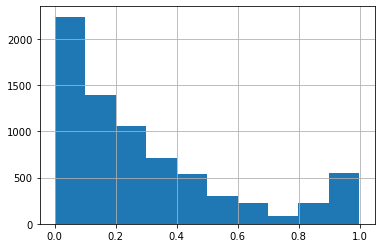

In [28]:
answer_full.TARGET.hist()